# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for flw
Gradients are different at (711, 2). Analytic: 0.00004, Numeric: 0.00006


False

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for flw
Gradients are different at (0, 0). Analytic: -0.01976, Numeric: -0.01966


False

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.217215, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.155566, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.101459, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286570, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.170695, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.067441, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.367471, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.110023, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.226594, Train accuracy: 0.207667, val accuracy: 0.215000
Loss: 2.068688, Train accuracy: 0.230111, val accuracy: 0.235000
Loss: 2.120957, Train accuracy: 0.256444, val accuracy: 0.258000
Loss: 2.110639, Train accuracy: 0.268778, val accuracy: 0.268000
Loss: 2.121036, Train accuracy: 0.282556, val accuracy: 0.287000
Loss: 1.999364, Train accuracy: 0.300111, val accuracy: 0.306000
Loss: 2.058220, Train accuracy: 0.322222, val accuracy: 0.325000
Loss: 1.853882, Train acc

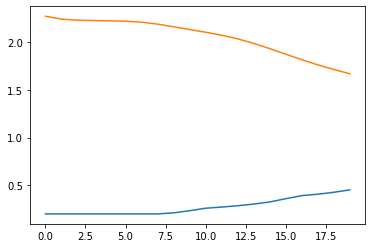

In [10]:
plt.plot(train_history)
#plt.plot(val_history)
plt.plot(loss_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

Loss: 2.246074, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.372562, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209350, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260245, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.182553, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.195048, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.086410, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321902, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248486, Train accuracy: 0.200889, val accuracy: 0.210000
Loss: 2.193291, Train accuracy: 0.225889, val accuracy: 0.230000
Loss: 2.084251, Train accuracy: 0.241111, val accuracy: 0.242000
Loss: 2.093536, Train accuracy: 0.268000, val accuracy: 0.267000
Loss: 2.380028, Train accuracy: 0.276667, val accuracy: 0.271000
Loss: 1.764889, Train accuracy: 0.280556, val accuracy: 0.286000
Loss: 2.301798, Train accuracy: 0.299778, val accuracy: 0.306000
Loss: 1.942206, Train acc

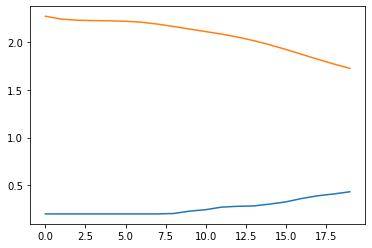

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

plt.plot(train_history)
#plt.plot(val_history)
plt.plot(loss_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

Loss: 2.150784, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.685559, Train accuracy: 0.342222, val accuracy: 0.347000
Loss: 1.407328, Train accuracy: 0.532778, val accuracy: 0.530000
Loss: 1.515136, Train accuracy: 0.601000, val accuracy: 0.592000
Loss: 1.385950, Train accuracy: 0.666444, val accuracy: 0.640000
Loss: 1.675235, Train accuracy: 0.661000, val accuracy: 0.656000
Loss: 1.065633, Train accuracy: 0.708000, val accuracy: 0.672000
Loss: 1.048001, Train accuracy: 0.712889, val accuracy: 0.665000
Loss: 1.338748, Train accuracy: 0.726667, val accuracy: 0.692000
Loss: 1.371619, Train accuracy: 0.738444, val accuracy: 0.696000
Loss: 0.742175, Train accuracy: 0.769889, val accuracy: 0.706000
Loss: 0.866305, Train accuracy: 0.772556, val accuracy: 0.705000
Loss: 0.841246, Train accuracy: 0.795889, val accuracy: 0.714000
Loss: 0.597965, Train accuracy: 0.779778, val accuracy: 0.712000
Loss: 1.439451, Train accuracy: 0.797000, val accuracy: 0.731000
Loss: 1.040094, Train acc

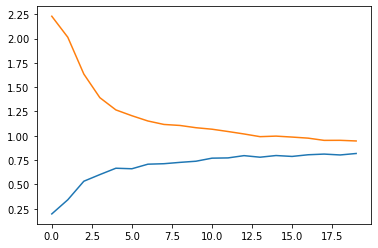

In [12]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

plt.plot(train_history)
#plt.plot(val_history)
plt.plot(loss_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

Loss: 2.351801, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319693, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295926, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.345443, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310013, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.326544, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.255641, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.199259, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.164561, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.025661, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.883798, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.263931, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.662918, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.245522, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.943906, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.663953, Train acc

Loss: 1.412599, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.212850, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.196541, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 1.280346, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.403204, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.229377, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.400568, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.391042, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.102808, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.445285, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.406323, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.219193, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.449330, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.304464, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.494726, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.327706, Train acc

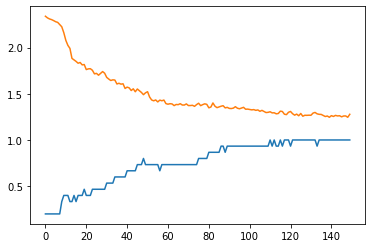

In [13]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

plt.plot(train_history)
#plt.plot(val_history)
plt.plot(loss_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [14]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.272282, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.402415, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.152981, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.492752, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.451414, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 0.499783, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 0.849799, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 0.994892, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 0.185761, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.345067, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.273988, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.400967, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 1.267714, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.152455, Train accuracy: 0.666667, val accuracy: 0.133333
Loss: 0.076956, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.180364, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [15]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-2
reg_strength = 1e-4
learning_rate_decay = 0.99
hidden_layer_size = 128
num_epochs = 50
batch_size = 64

best_classifier = None

loss_history = []
train_history = []
val_history = []
dataset = Dataset(train_X, train_y, val_X, val_y)
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 25, 
                                        hidden_layer_size = hidden_layer_size, 
                                        reg = reg_strength)

trainer = Trainer(model, dataset, MomentumSGD(), 
                                      num_epochs = num_epochs, 
                                      batch_size = batch_size, 
                                      learning_rate = learning_rates, 
                                      learning_rate_decay = learning_rate_decay)
# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

best_classifier = model
# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % max(val_history))

Loss: 2.372776, Train accuracy: 0.187444, val accuracy: 0.206000
Loss: 2.254541, Train accuracy: 0.196889, val accuracy: 0.207000
Loss: 2.220164, Train accuracy: 0.166556, val accuracy: 0.168000
Loss: 2.027515, Train accuracy: 0.210444, val accuracy: 0.216000
Loss: 1.938607, Train accuracy: 0.253889, val accuracy: 0.263000
Loss: 1.648154, Train accuracy: 0.341667, val accuracy: 0.338000
Loss: 1.589845, Train accuracy: 0.403556, val accuracy: 0.414000
Loss: 1.778226, Train accuracy: 0.489889, val accuracy: 0.486000
Loss: 1.350328, Train accuracy: 0.550556, val accuracy: 0.554000
Loss: 1.008276, Train accuracy: 0.589556, val accuracy: 0.579000
Loss: 1.242756, Train accuracy: 0.623111, val accuracy: 0.608000
Loss: 1.108974, Train accuracy: 0.657667, val accuracy: 0.643000
Loss: 1.332240, Train accuracy: 0.683556, val accuracy: 0.663000
Loss: 0.976140, Train accuracy: 0.690889, val accuracy: 0.670000
Loss: 1.478691, Train accuracy: 0.708000, val accuracy: 0.687000
Loss: 0.847256, Train acc

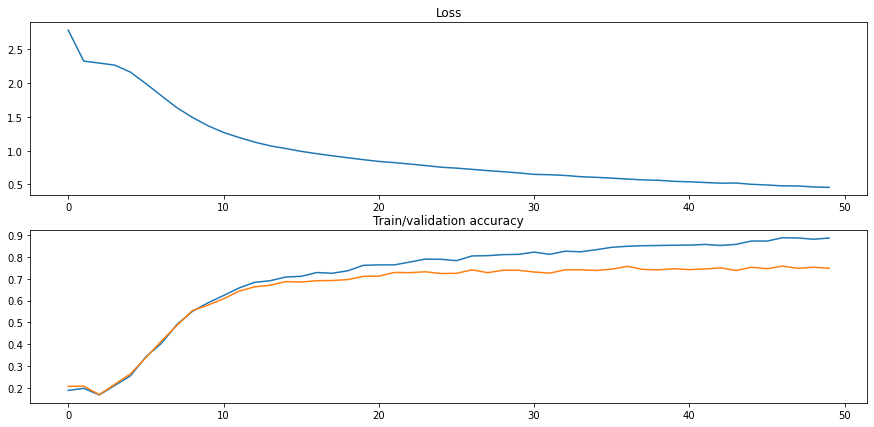

In [16]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [17]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.716000
